# Medical Diagnosis with Decision Trees and Regression Analysis

This project demonstrates the application of interpretable machine learning models for medical diagnosis, specifically focusing on:
1. **Decision Trees for Medical Diagnosis** - Predicting inflammation and nephritis from patient symptoms
2. **Regression Analysis** - Comparing LASSO, Ridge, PCR, and XGBoost for crime rate prediction

## 1. Decision Trees as Interpretable Models

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import warnings
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

warnings.filterwarnings('ignore')

### (a) Load and Preprocess Data

In [ ]:
col_names = [
    'temp', 'nausea', 'lumbar_pain', 'urine_pushing',
    'micturition_pains', 'urethra_burning', 'inflammation', 'nephritis'
]

df_acute = pd.read_csv('../data/diagnosis.csv', sep='\t', names=col_names, encoding='utf-16')

# Convert temperature from string to float (replace comma with decimal point)
df_acute['temp'] = df_acute['temp'].str.replace(',', '.').astype(float)

# Convert categorical variables from yes/no to 1/0
for col in df_acute.columns[1:]:
    df_acute[col] = df_acute[col].apply(lambda x: 1 if x == 'yes' else 0)

X = df_acute[['temp', 'nausea', 'lumbar_pain', 'urine_pushing', 'micturition_pains', 'urethra_burning']]
y_inflammation = df_acute['inflammation']
y_nephritis = df_acute['nephritis']

### (b) Build Decision Trees

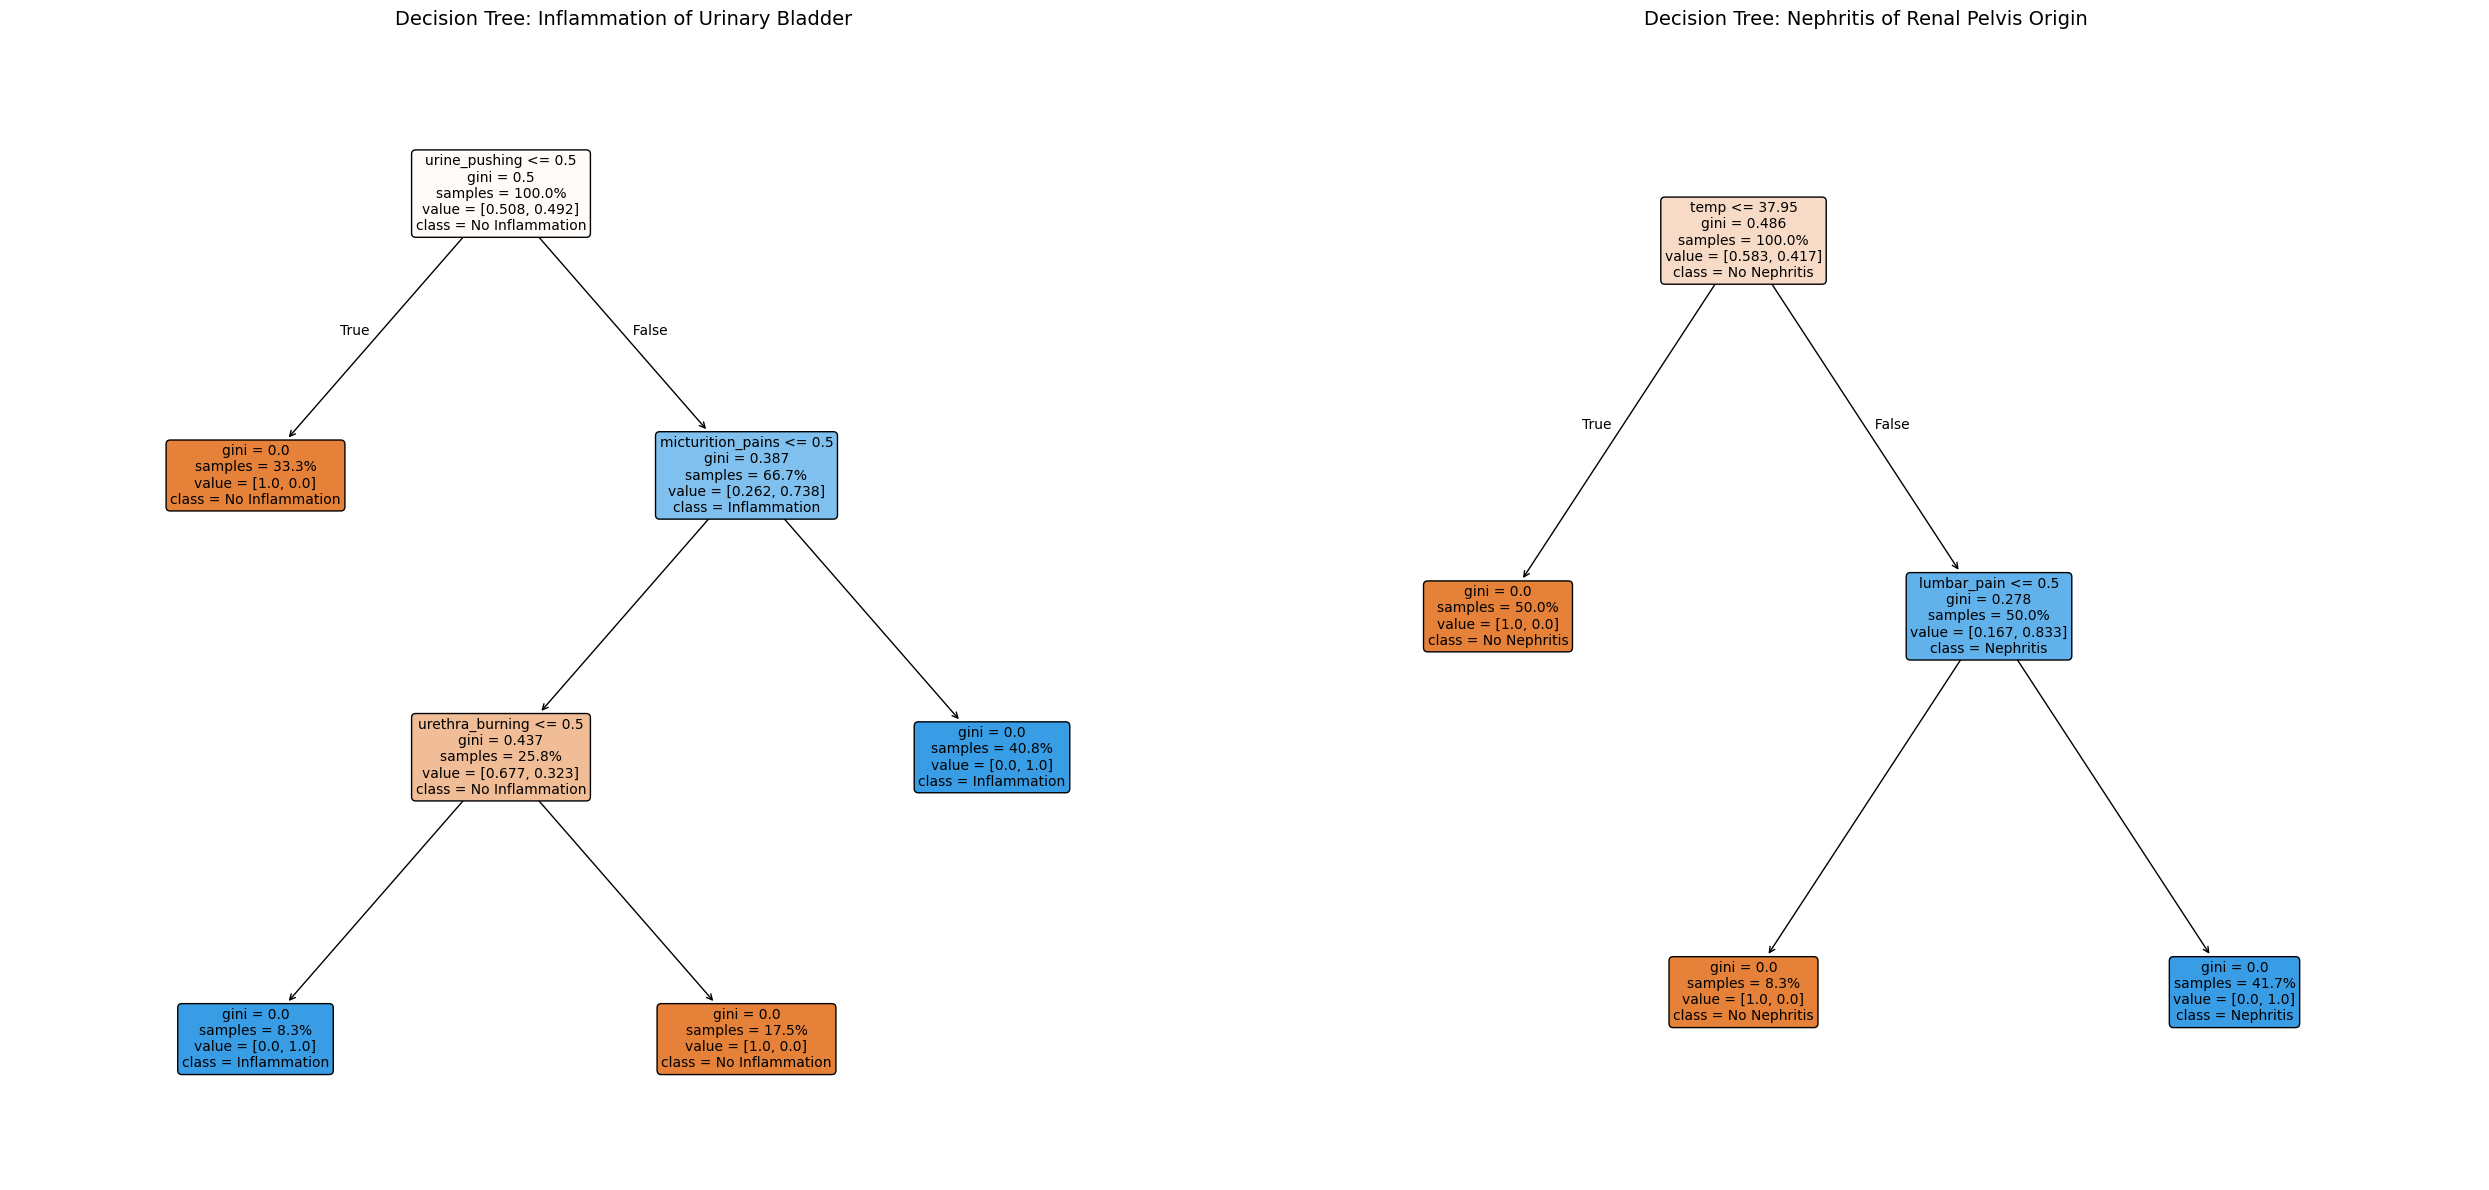

In [ ]:
tree_inflammation = DecisionTreeClassifier(random_state=42)
tree_inflammation.fit(X, y_inflammation)

tree_nephritis = DecisionTreeClassifier(random_state=42)
tree_nephritis.fit(X, y_nephritis)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 12))

plot_tree(tree_inflammation,
          feature_names=X.columns,
          class_names=['No Inflammation', 'Inflammation'],
          filled=True,
          rounded=True,
          fontsize=10,
          impurity=True,
          proportion=True,
          ax=ax1)
ax1.set_title("Decision Tree: Inflammation of Urinary Bladder", fontsize=14, pad=20)

plot_tree(tree_nephritis,
          feature_names=X.columns,
          class_names=['No Nephritis', 'Nephritis'],
          filled=True,
          rounded=True,
          fontsize=10,
          impurity=True,
          proportion=True,
          ax=ax2)
ax2.set_title("Decision Tree: Nephritis of Renal Pelvis Origin", fontsize=14, pad=20)

plt.tight_layout()
plt.show()

### (c) Extract Decision Rules

In [ ]:
def tree_to_pseudo(tree, feature_names):
    """
    Convert a decision tree to pseudo-code format.
    
    Parameters:
    -----------
    tree : DecisionTreeClassifier
        The trained decision tree model
    feature_names : list
        List of feature names
    """
    left = tree.tree_.children_left
    right = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value

    def recurse(left, right, threshold, features, node, depth=0):
        indent = "  " * depth
        if threshold[node] != -2:
            print(f"{indent}if ( {features[node]} <= {threshold[node]} ) {{")
            if left[node] != -1:
                recurse(left, right, threshold, features, left[node], depth + 1)
            print(f"{indent}}} else {{")
            if right[node] != -1:
                recurse(left, right, threshold, features, right[node], depth + 1)
            print(f"{indent}}}")
        else:
            leaf_str = np.array2string(value[node], separator=' ')
            print(f"{indent}return {leaf_str}")

    recurse(left, right, threshold, features, 0)

rules_inflammation = export_text(tree_inflammation, feature_names=list(X.columns))
print("Inflammation Tree Rules:")
print(rules_inflammation)
print("\nInflammation IF-THEN Rules:")
tree_to_pseudo(tree_inflammation, list(X.columns))

rules_nephritis = export_text(tree_nephritis, feature_names=list(X.columns))
print("\n\nNephritis Tree Rules:")
print(rules_nephritis)
print("\nNephritis IF-THEN Rules:")
tree_to_pseudo(tree_nephritis, list(X.columns))

Inflammation Tree Rules:
|--- urine_pushing <= 0.50
|   |--- class: 0
|--- urine_pushing >  0.50
|   |--- micturition_pains <= 0.50
|   |   |--- urethra_burning <= 0.50
|   |   |   |--- class: 1
|   |   |--- urethra_burning >  0.50
|   |   |   |--- class: 0
|   |--- micturition_pains >  0.50
|   |   |--- class: 1


Inflammation IF-THEN Rules:
if ( urine_pushing <= 0.5 ) {
  return [[1. 0.]]
} else {
  if ( micturition_pains <= 0.5 ) {
    if ( urethra_burning <= 0.5 ) {
      return [[0. 1.]]
    } else {
      return [[1. 0.]]
    }
  } else {
    return [[0. 1.]]
  }
}


Nephritis Tree Rules:
|--- temp <= 37.95
|   |--- class: 0
|--- temp >  37.95
|   |--- lumbar_pain <= 0.50
|   |   |--- class: 0
|   |--- lumbar_pain >  0.50
|   |   |--- class: 1


Nephritis IF-THEN Rules:
if ( temp <= 37.95000076293945 ) {
  return [[1. 0.]]
} else {
  if ( lumbar_pain <= 0.5 ) {
    return [[1. 0.]]
  } else {
    return [[0. 1.]]
  }
}


### (d) Cost-Complexity Pruning

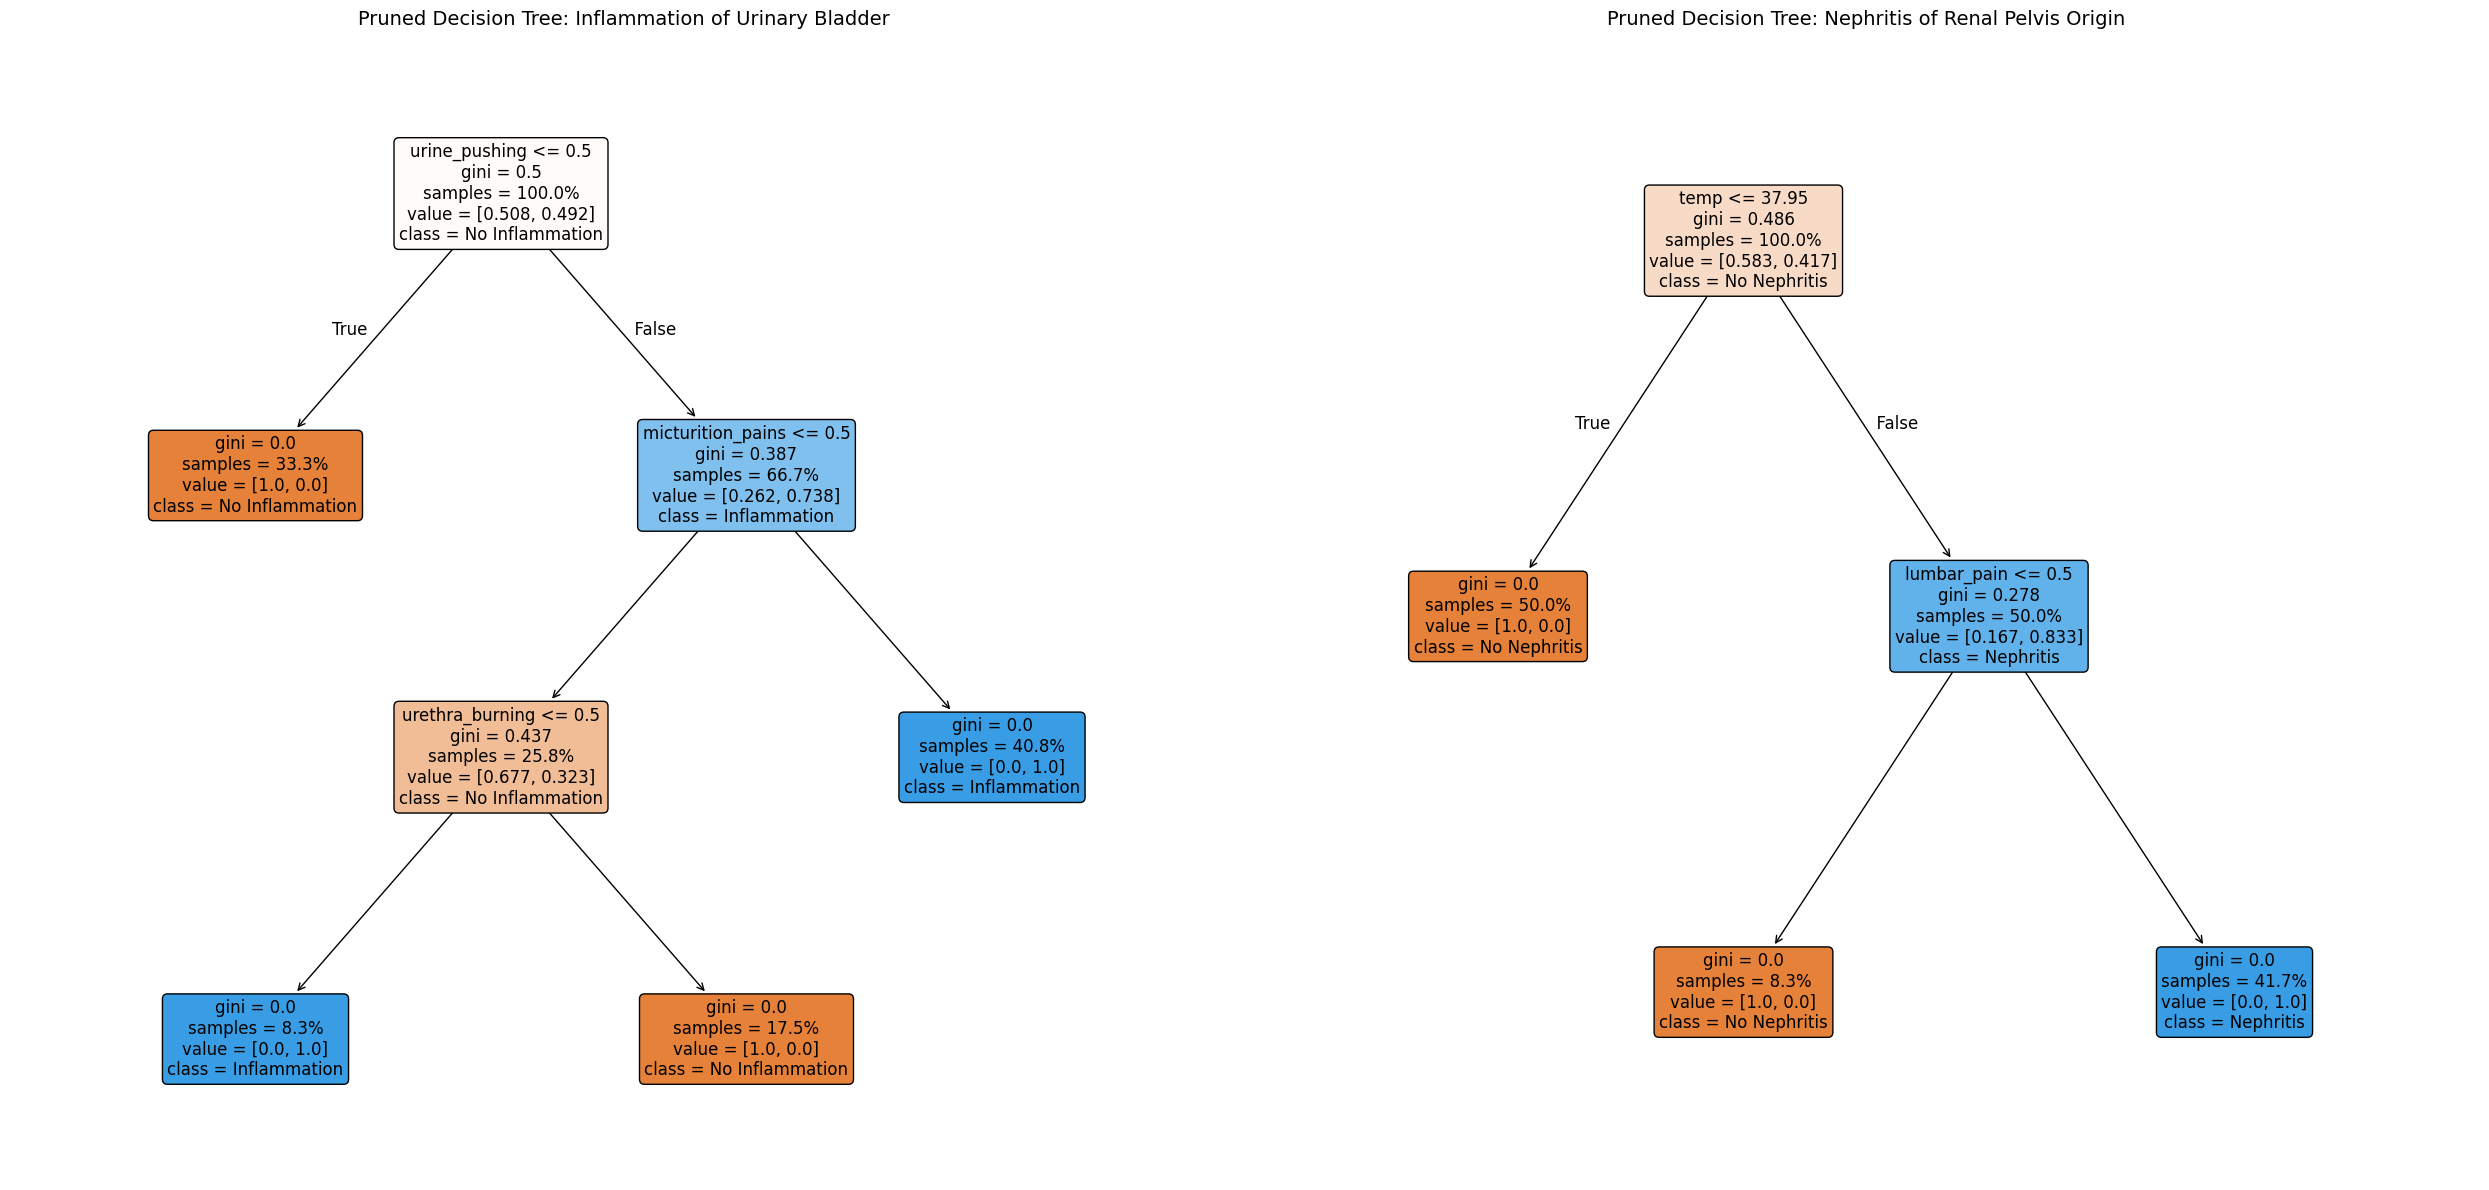

Pruned Inflammation Tree Rules:
|--- urine_pushing <= 0.50
|   |--- class: 0
|--- urine_pushing >  0.50
|   |--- micturition_pains <= 0.50
|   |   |--- urethra_burning <= 0.50
|   |   |   |--- class: 1
|   |   |--- urethra_burning >  0.50
|   |   |   |--- class: 0
|   |--- micturition_pains >  0.50
|   |   |--- class: 1


Pruned Inflammation IF-THEN Rules:
if ( urine_pushing <= 0.5 ) {
  return [[1. 0.]]
} else {
  if ( micturition_pains <= 0.5 ) {
    if ( urethra_burning <= 0.5 ) {
      return [[0. 1.]]
    } else {
      return [[1. 0.]]
    }
  } else {
    return [[0. 1.]]
  }
}


Pruned Nephritis Tree Rules:
|--- temp <= 37.95
|   |--- class: 0
|--- temp >  37.95
|   |--- lumbar_pain <= 0.50
|   |   |--- class: 0
|   |--- lumbar_pain >  0.50
|   |   |--- class: 1


Pruned Nephritis IF-THEN Rules:
if ( temp <= 37.95000076293945 ) {
  return [[1. 0.]]
} else {
  if ( lumbar_pain <= 0.5 ) {
    return [[1. 0.]]
  } else {
    return [[0. 1.]]
  }
}


In [ ]:
def find_optimal_alpha(X, y, cv_folds=5):
    """
    Find optimal cost-complexity pruning alpha using cross-validation.
    
    Parameters:
    -----------
    X : array-like
        Feature matrix
    y : array-like
        Target vector
    cv_folds : int
        Number of cross-validation folds
        
    Returns:
    --------
    float
        Optimal alpha value
    """
    temp_tree = DecisionTreeClassifier(random_state=42)
    temp_tree.fit(X, y)
    path = temp_tree.cost_complexity_pruning_path(X, y)
    ccp_alphas = path.ccp_alphas[:-1]
    
    if len(ccp_alphas) == 0:
        return 0.0
    
    alpha_scores = []
    for alpha in ccp_alphas:
        clf = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
        scores = cross_val_score(clf, X, y, cv=cv_folds, scoring='accuracy')
        alpha_scores.append(np.mean(scores))
    
    best_alpha = ccp_alphas[np.argmax(alpha_scores)]
    return best_alpha

best_alpha_inflammation = find_optimal_alpha(X, y_inflammation)
pruned_tree_inflammation = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha_inflammation)
pruned_tree_inflammation.fit(X, y_inflammation)

best_alpha_nephritis = find_optimal_alpha(X, y_nephritis)
pruned_tree_nephritis = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha_nephritis)
pruned_tree_nephritis.fit(X, y_nephritis)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 12))

plot_tree(pruned_tree_inflammation,
          feature_names=X.columns,
          class_names=['No Inflammation', 'Inflammation'],
          filled=True,
          rounded=True,
          fontsize=12,
          impurity=True,
          proportion=True,
          ax=ax1)
ax1.set_title("Pruned Decision Tree: Inflammation of Urinary Bladder", fontsize=14, pad=20)

plot_tree(pruned_tree_nephritis,
          feature_names=X.columns,
          class_names=['No Nephritis', 'Nephritis'],
          filled=True,
          rounded=True,
          fontsize=12,
          impurity=True,
          proportion=True,
          ax=ax2)
ax2.set_title("Pruned Decision Tree: Nephritis of Renal Pelvis Origin", fontsize=14, pad=20)

plt.tight_layout()
plt.show()

pruned_rules_inflammation = export_text(pruned_tree_inflammation, feature_names=list(X.columns))
print("Pruned Inflammation Tree Rules:")
print(pruned_rules_inflammation)
print("\nPruned Inflammation IF-THEN Rules:")
tree_to_pseudo(pruned_tree_inflammation, list(X.columns))

pruned_rules_nephritis = export_text(pruned_tree_nephritis, feature_names=list(X.columns))
print("\n\nPruned Nephritis Tree Rules:")
print(pruned_rules_nephritis)
print("\nPruned Nephritis IF-THEN Rules:")
tree_to_pseudo(pruned_tree_nephritis, list(X.columns))

## 2. Regression Analysis: LASSO, Ridge, PCR, and Boosting

### (a) Load Data

In [ ]:
df = pd.read_csv('../data/communities.csv', header=None, na_values=['?'])

X = df.iloc[:, 5:127].copy()
y = df.iloc[:, 127].copy()

# Train/test split
X_train = X.iloc[:1495]
X_test = X.iloc[1495:]
y_train = y.iloc[:1495]
y_test = y.iloc[1495:]

### (b) Handle Missing Values

In [ ]:
for col in X_train.columns:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

y_train = pd.to_numeric(y_train, errors='coerce')
y_test = pd.to_numeric(y_test, errors='coerce')

train_mask = ~y_train.isna()
test_mask = ~y_test.isna()

X_train = X_train[train_mask]
y_train = y_train[train_mask]
X_test = X_test[test_mask]
y_test = y_test[test_mask]

variances = X_train.var()
zero_var_features = variances[variances == 0].index
all_missing_features = X_train.columns[X_train.isnull().all()]

non_predictive = list(zero_var_features) + list(all_missing_features)
X_train_clean = X_train.drop(columns=non_predictive)
X_test_clean = X_test.drop(columns=non_predictive)

imputer = SimpleImputer(strategy='median')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train_clean), 
                               columns=X_train_clean.columns,
                               index=X_train_clean.index)
X_test_imputed = pd.DataFrame(imputer.transform(X_test_clean), 
                              columns=X_test_clean.columns,
                              index=X_test_clean.index)

X_train = X_train_imputed
X_test = X_test_imputed

### (c) Correlation Matrix

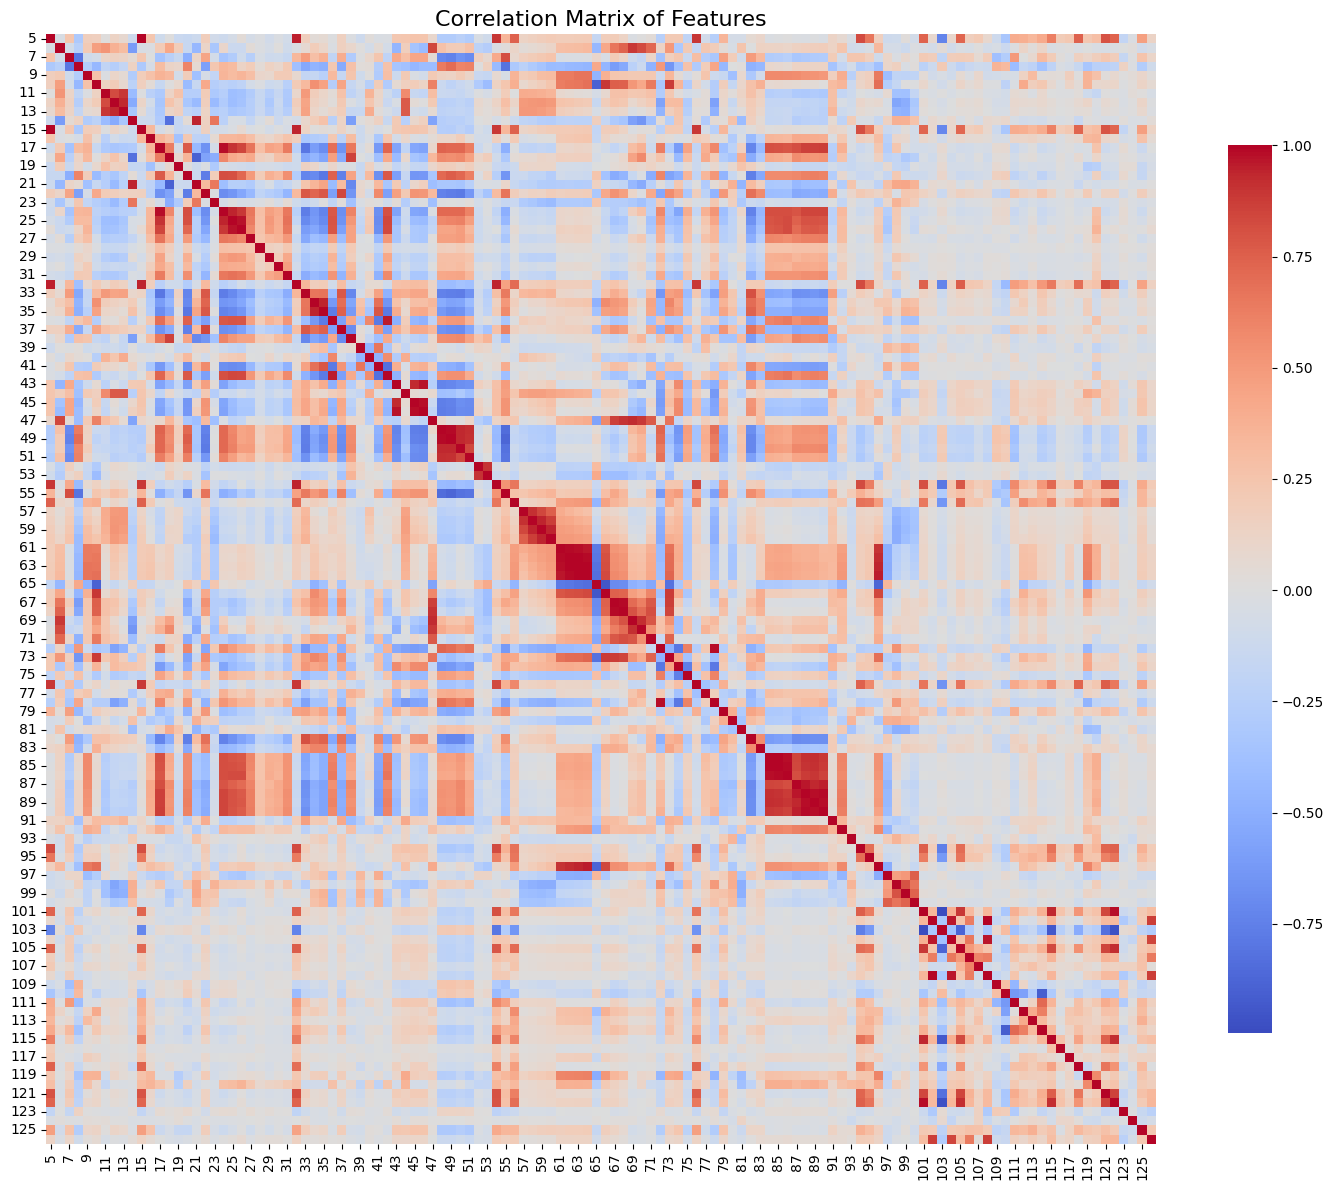

In [ ]:
plt.figure(figsize=(15, 12))
correlation_matrix = X_train.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, 
            square=True, cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix of Features', fontsize=16)
plt.tight_layout()
plt.show()

### (d) Calculate Coefficient of Variation

In [ ]:
means = X_train.mean()
stds = X_train.std()
cv_values = np.where(np.abs(means) < 1e-10, np.inf, stds / np.abs(means))

cv_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Mean': means,
    'Std': stds,
    'CV': cv_values
}).sort_values('CV', ascending=False)

n_features = int(np.floor(np.sqrt(128)))
top_cv_features = cv_df.head(n_features)['Feature'].tolist()

### (e) Feature Analysis: Scatter Plots and Box Plots

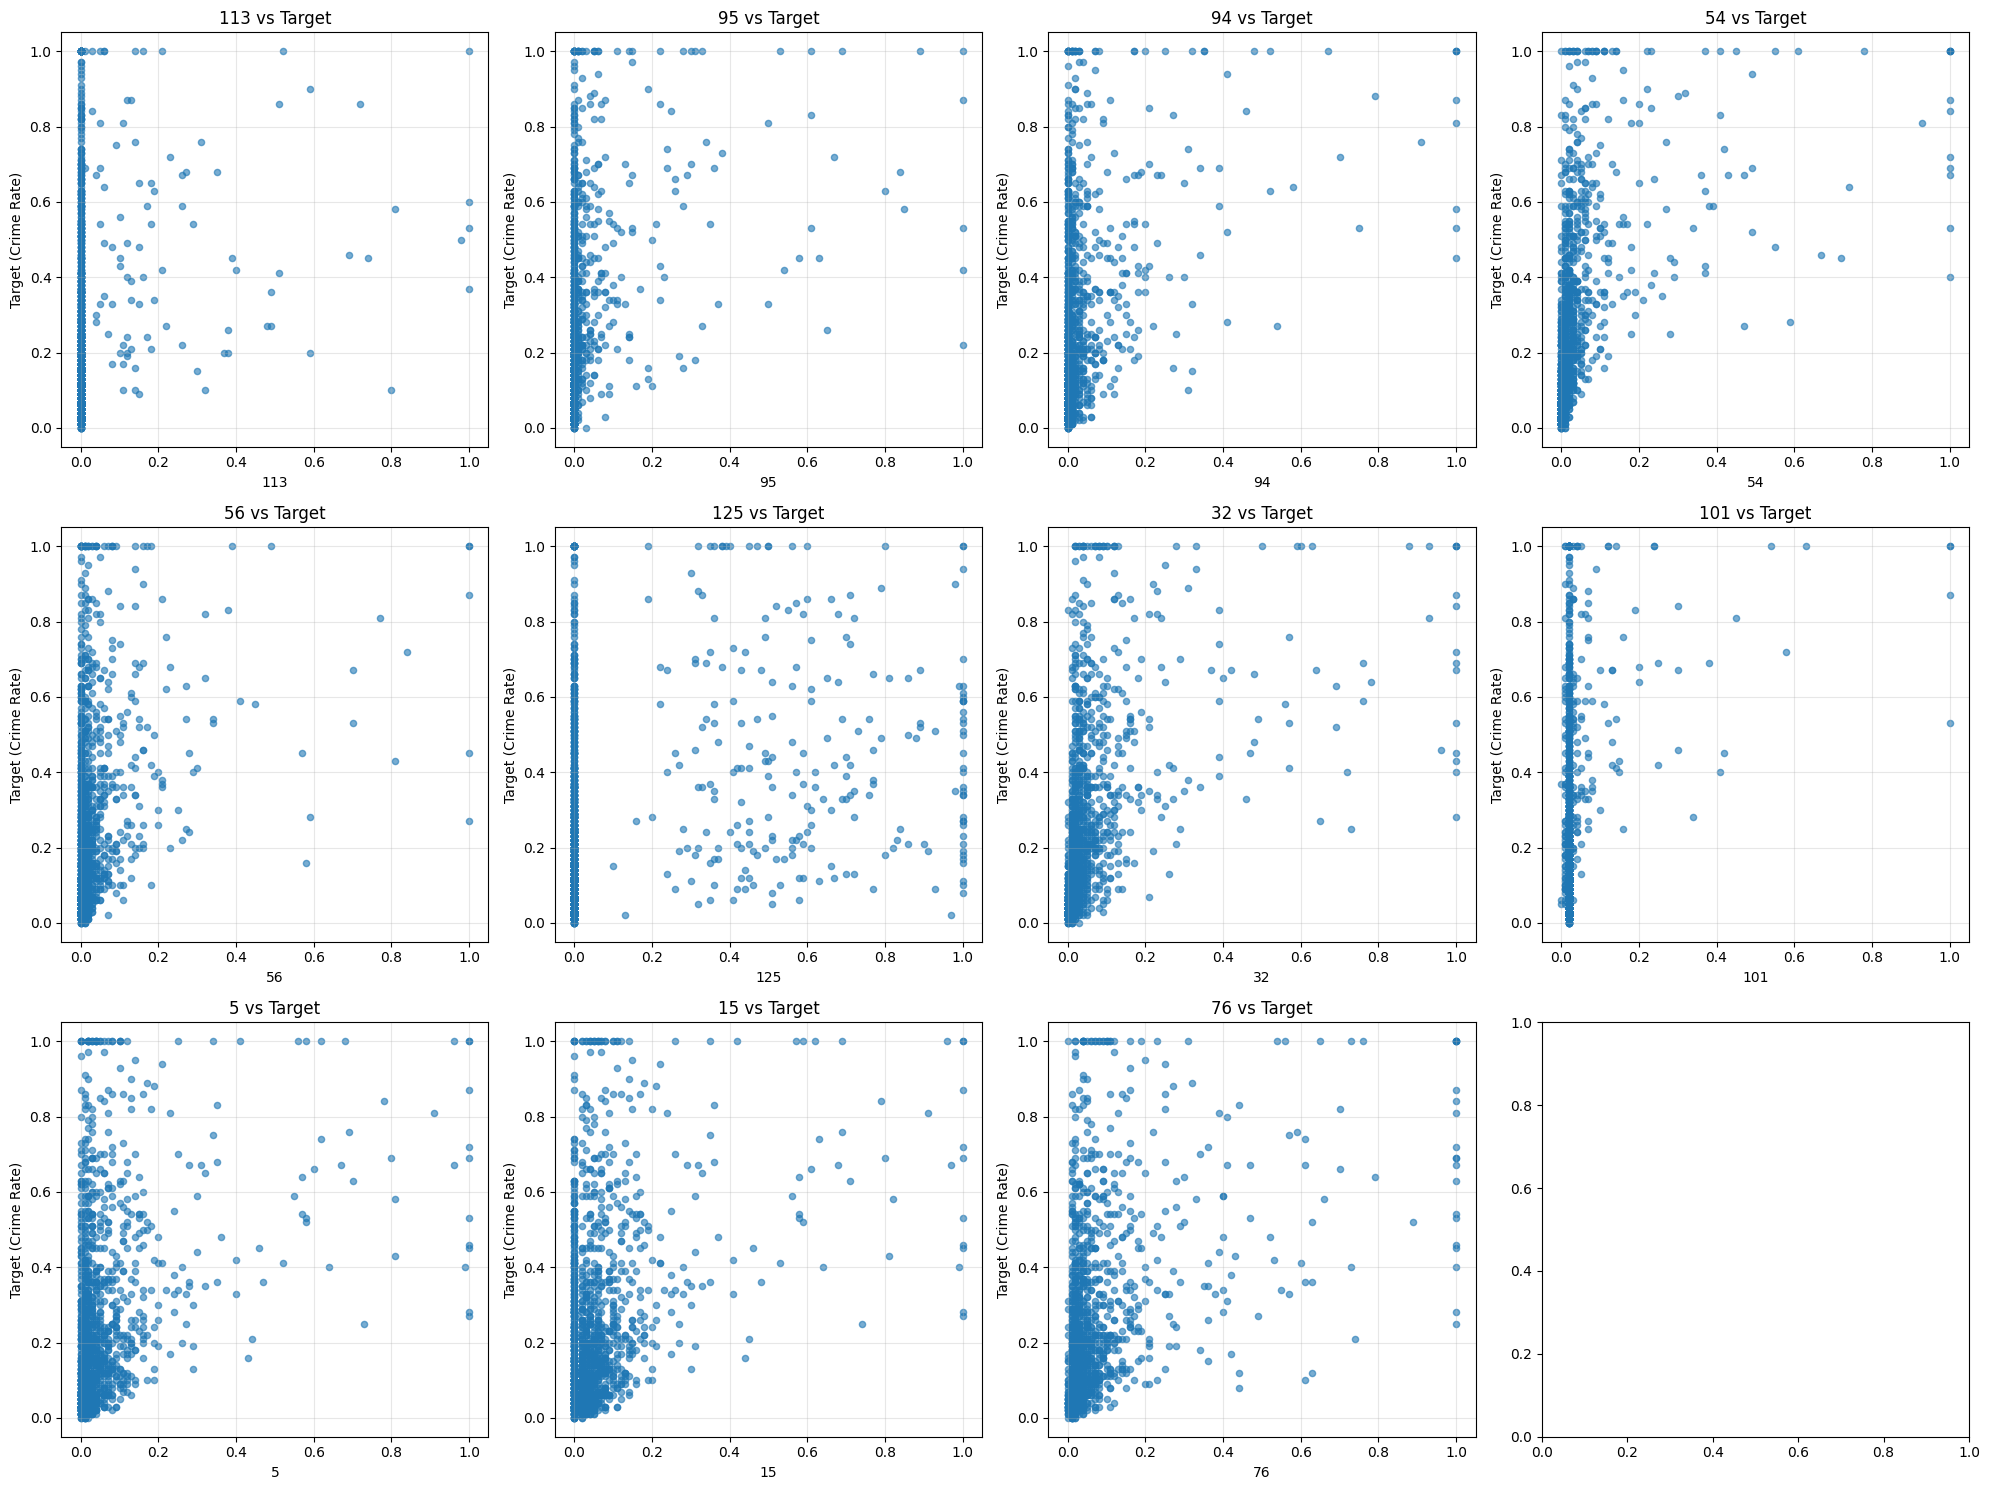

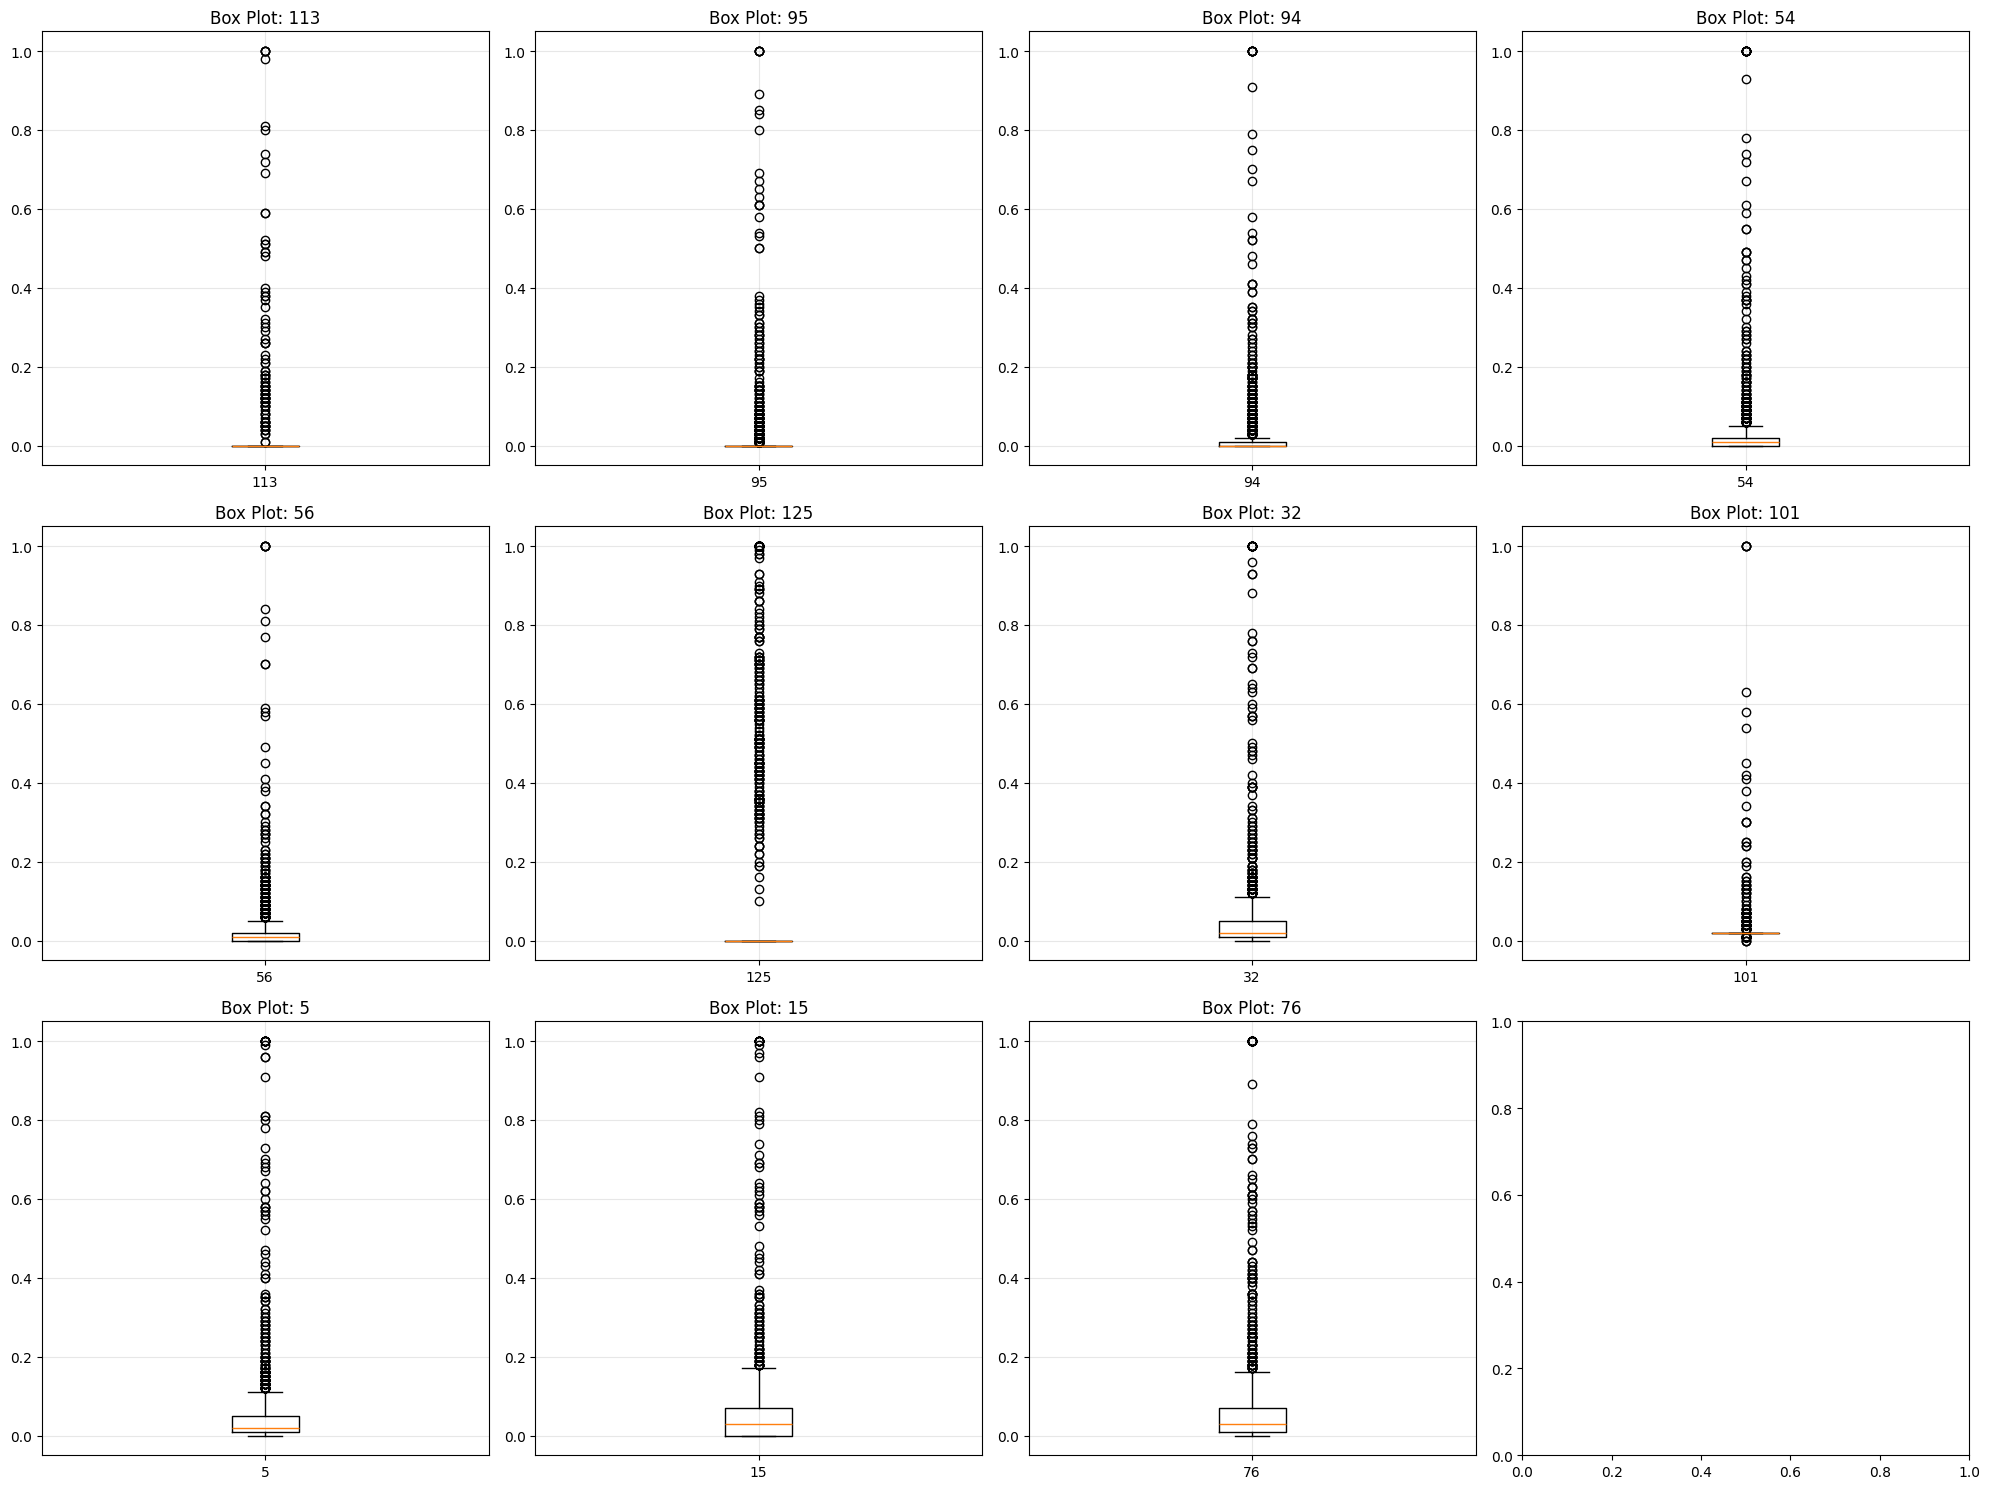

Analysis of Top CV Features:
113: correlation = 0.2011, CV = 5.5271
95: correlation = 0.3323, CV = 4.2929
94: correlation = 0.3729, CV = 3.4710
54: correlation = 0.4629, CV = 3.0590
56: correlation = 0.2947, CV = 2.9266
125: correlation = 0.3319, CV = 2.5529
32: correlation = 0.4423, CV = 2.3424
101: correlation = 0.2767, CV = 2.2480
5: correlation = 0.3642, CV = 2.2411
15: correlation = 0.3616, CV = 2.0385
76: correlation = 0.4224, CV = 1.9685


In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

for i, feature in enumerate(top_cv_features[:11]):
    if i < len(axes):
        axes[i].scatter(X_train[feature], y_train, alpha=0.6, s=20)
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Target (Crime Rate)')
        axes[i].set_title(f'{feature} vs Target')
        axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

for i, feature in enumerate(top_cv_features[:11]):
    if i < len(axes):
        data_to_plot = [X_train[feature].values]
        axes[i].boxplot(data_to_plot, labels=[feature])
        axes[i].set_title(f'Box Plot: {feature}')
        axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Analysis of Top CV Features:")
for feature in top_cv_features[:11]:
    correlation = np.corrcoef(X_train[feature], y_train)[0, 1]
    print(f"{feature}: correlation = {correlation:.4f}, CV = {cv_df[cv_df['Feature'] == feature]['CV'].iloc[0]:.4f}")

**Key Insight:** Scatter plots alone are insufficient. High CV ≠ High Correlation (e.g., Feature 113: CV=5.53, correlation=0.20). Correlation coefficients are needed to assess true significance. Scatter plots show distribution, but statistical measures (like correlation analysis) are required to determine actual feature significance for prediction.

### (f) Linear Regression Baseline

Linear Regression - Test MSE: 0.017966, Test R²: 0.622204


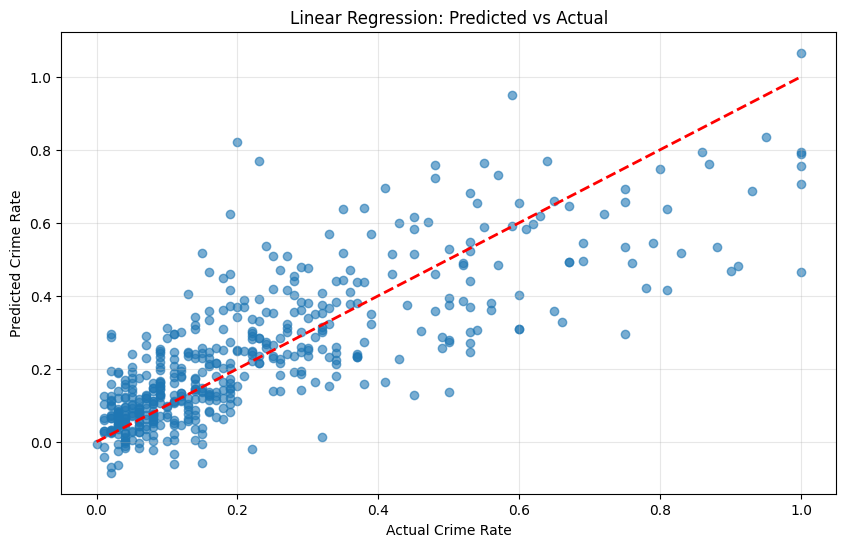

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Linear Regression - Test MSE: {test_mse:.6f}, Test R²: {test_r2:.6f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Crime Rate')
plt.ylabel('Predicted Crime Rate')
plt.title('Linear Regression: Predicted vs Actual')
plt.grid(True, alpha=0.3)
plt.show()

### (g) Ridge Regression

Ridge Regression - Test MSE: 0.017504, Test R²: 0.631931


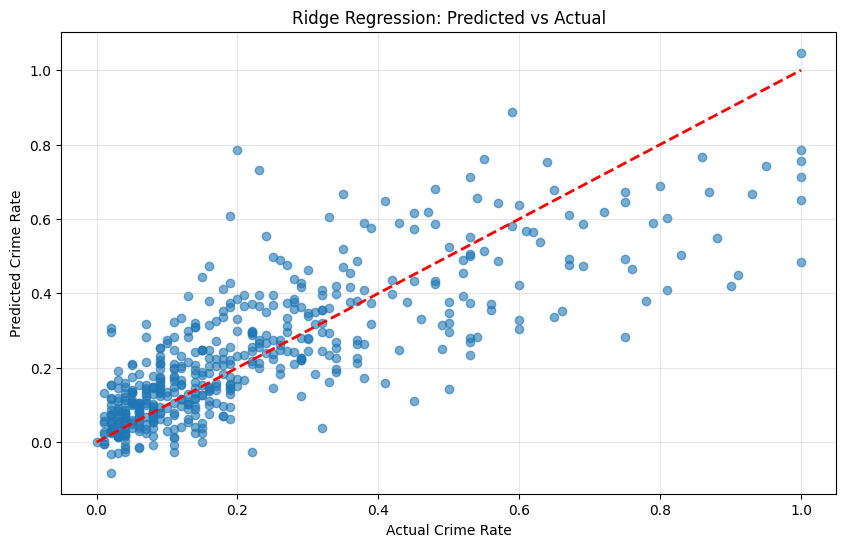

In [ ]:
alphas = np.logspace(-4, 4, 50)
ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train, y_train)

best_alpha = ridge_cv.alpha_
ridge_model = Ridge(alpha=best_alpha)
ridge_model.fit(X_train, y_train)

y_train_pred_ridge = ridge_model.predict(X_train)
y_test_pred_ridge = ridge_model.predict(X_test)

train_mse_ridge = mean_squared_error(y_train, y_train_pred_ridge)
test_mse_ridge = mean_squared_error(y_test, y_test_pred_ridge)
train_r2_ridge = r2_score(y_train, y_train_pred_ridge)
test_r2_ridge = r2_score(y_test, y_test_pred_ridge)

print(f"Ridge Regression - Test MSE: {test_mse_ridge:.6f}, Test R²: {test_r2_ridge:.6f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_ridge, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Crime Rate')
plt.ylabel('Predicted Crime Rate')
plt.title('Ridge Regression: Predicted vs Actual')
plt.grid(True, alpha=0.3)
plt.show()

### (h) LASSO Regression

LASSO (Non-standardized) - Test MSE: 0.017618, Test R²: 0.629531
Selected Features: 74
Selected Feature Names: [7, 9, 11, 12, 16, 18, 19, 20, 21, 22, 23, 26, 27, 28, 29, 30, 31, 33, 34, 38, 39, 41, 43, 44, 45, 49, 50, 51, 53, 54, 55, 56, 57, 60, 64, 66, 68, 69, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 87, 90, 91, 92, 93, 94, 95, 96, 97, 99, 104, 107, 109, 111, 112, 113, 116, 117, 118, 119, 120, 121, 123, 124]


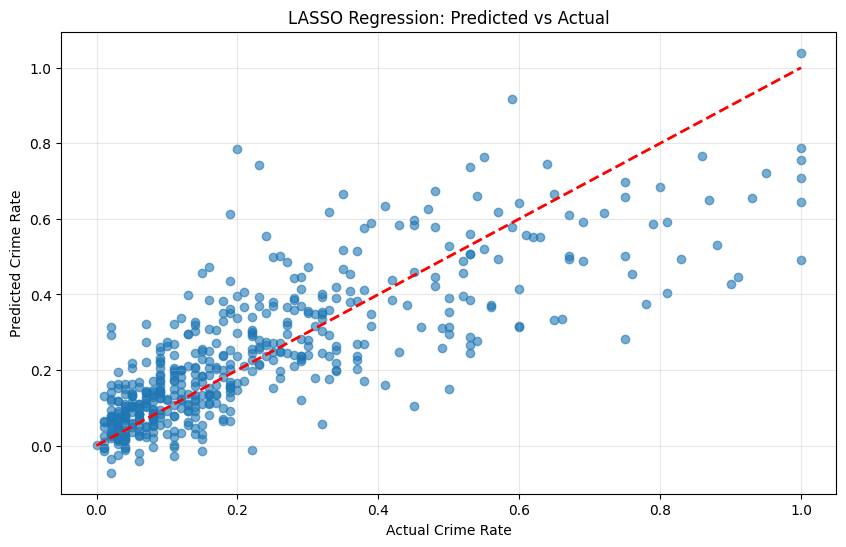

In [ ]:
lasso_cv = LassoCV(cv=5, random_state=42, max_iter=2000)
lasso_cv.fit(X_train, y_train)

best_alpha_lasso = lasso_cv.alpha_
lasso_model = Lasso(alpha=best_alpha_lasso, max_iter=2000)
lasso_model.fit(X_train, y_train)

y_train_pred_lasso = lasso_model.predict(X_train)
y_test_pred_lasso = lasso_model.predict(X_test)

train_mse_lasso = mean_squared_error(y_train, y_train_pred_lasso)
test_mse_lasso = mean_squared_error(y_test, y_test_pred_lasso)
train_r2_lasso = r2_score(y_train, y_train_pred_lasso)
test_r2_lasso = r2_score(y_test, y_test_pred_lasso)

selected_features = np.sum(lasso_model.coef_ != 0)
selected_feature_names = X_train.columns[lasso_model.coef_ != 0].tolist()

print(f"LASSO (Non-standardized) - Test MSE: {test_mse_lasso:.6f}, Test R²: {test_r2_lasso:.6f}")
print(f"Selected Features: {selected_features}")
print(f"Selected Feature Names: {selected_feature_names}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_lasso, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Crime Rate')
plt.ylabel('Predicted Crime Rate')
plt.title('LASSO Regression: Predicted vs Actual')
plt.grid(True, alpha=0.3)
plt.show()

LASSO (Standardized) - Test MSE: 0.017682, Test R²: 0.628180
Selected Features: 72
Selected Feature Names: [7, 9, 11, 12, 16, 18, 19, 20, 21, 22, 23, 26, 27, 28, 29, 30, 31, 33, 34, 38, 39, 43, 44, 45, 49, 50, 51, 53, 54, 55, 56, 58, 60, 64, 66, 68, 69, 72, 73, 74, 76, 77, 79, 80, 81, 82, 83, 87, 90, 91, 92, 93, 94, 95, 96, 99, 104, 105, 107, 109, 111, 112, 113, 115, 116, 117, 118, 119, 120, 121, 123, 124]


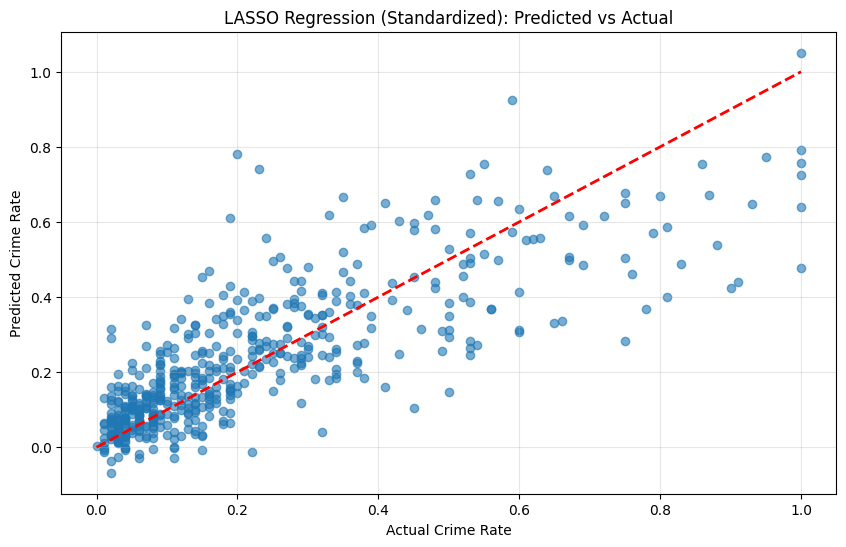

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

lasso_cv_scaled = LassoCV(cv=5, random_state=42, max_iter=2000)
lasso_cv_scaled.fit(X_train_scaled_df, y_train)

best_alpha_lasso_scaled = lasso_cv_scaled.alpha_
lasso_model_scaled = Lasso(alpha=best_alpha_lasso_scaled, max_iter=2000)
lasso_model_scaled.fit(X_train_scaled_df, y_train)

y_train_pred_lasso_scaled = lasso_model_scaled.predict(X_train_scaled_df)
y_test_pred_lasso_scaled = lasso_model_scaled.predict(X_test_scaled_df)

train_mse_lasso_scaled = mean_squared_error(y_train, y_train_pred_lasso_scaled)
test_mse_lasso_scaled = mean_squared_error(y_test, y_test_pred_lasso_scaled)
train_r2_lasso_scaled = r2_score(y_train, y_train_pred_lasso_scaled)
test_r2_lasso_scaled = r2_score(y_test, y_test_pred_lasso_scaled)

selected_features_scaled = np.sum(lasso_model_scaled.coef_ != 0)
selected_feature_names_scaled = X_train.columns[lasso_model_scaled.coef_ != 0].tolist()

print(f"LASSO (Standardized) - Test MSE: {test_mse_lasso_scaled:.6f}, Test R²: {test_r2_lasso_scaled:.6f}")
print(f"Selected Features: {selected_features_scaled}")
print(f"Selected Feature Names: {selected_feature_names_scaled}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_lasso_scaled, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Crime Rate')
plt.ylabel('Predicted Crime Rate')
plt.title('LASSO Regression (Standardized): Predicted vs Actual')
plt.grid(True, alpha=0.3)
plt.show()

**LASSO Results Comparison:**

- **Non-standardized**: MSE = 0.017618, 74 features selected
- **Standardized**: MSE = 0.017682, 72 features selected

**Analysis:**

- **Nearly identical performance** 
- **Minimal difference in feature selection** (74 vs 72)
- Features appear already normalized

**Conclusion:** Either approach is acceptable for this dataset. The non-standardized version has marginally better MSE, but the difference is very small.

### (i) Principal Component Regression (PCR)

PCR - Test MSE: 0.018404, Test R²: 0.613005
Optimal Number of Components: 48


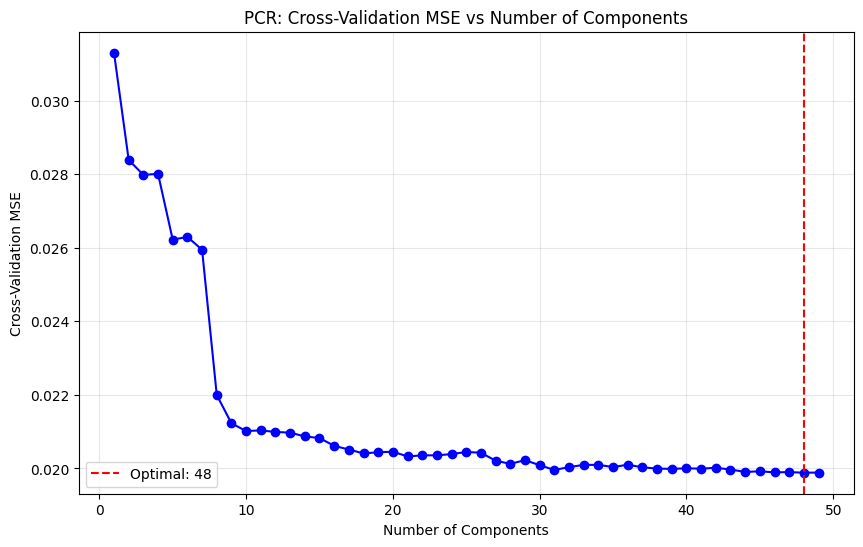

In [ ]:
X_train_pca = scaler.fit_transform(X_train)
X_test_pca = scaler.transform(X_test)

max_components = min(X_train.shape[0], X_train.shape[1])
n_components_range = range(1, min(max_components, 50))

cv_scores = []
for n_components in n_components_range:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n_components)),
        ('lr', LinearRegression())
    ])
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_scores.append(-np.mean(scores))

optimal_n_components = n_components_range[np.argmin(cv_scores)]

pca_final = PCA(n_components=optimal_n_components)
X_train_pca_final = pca_final.fit_transform(X_train_pca)
X_test_pca_final = pca_final.transform(X_test_pca)

pcr_model = LinearRegression()
pcr_model.fit(X_train_pca_final, y_train)

y_train_pred_pcr = pcr_model.predict(X_train_pca_final)
y_test_pred_pcr = pcr_model.predict(X_test_pca_final)

train_mse_pcr = mean_squared_error(y_train, y_train_pred_pcr)
test_mse_pcr = mean_squared_error(y_test, y_test_pred_pcr)
train_r2_pcr = r2_score(y_train, y_train_pred_pcr)
test_r2_pcr = r2_score(y_test, y_test_pred_pcr)

print(f"PCR - Test MSE: {test_mse_pcr:.6f}, Test R²: {test_r2_pcr:.6f}")
print(f"Optimal Number of Components: {optimal_n_components}")

plt.figure(figsize=(10, 6))
plt.plot(n_components_range, cv_scores, 'bo-')
plt.axvline(x=optimal_n_components, color='r', linestyle='--', label=f'Optimal: {optimal_n_components}')
plt.xlabel('Number of Components')
plt.ylabel('Cross-Validation MSE')
plt.title('PCR: Cross-Validation MSE vs Number of Components')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### (j) XGBoost Gradient Boosting

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


Best XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.01}
XGBoost - Test MSE: 0.016024, Test R²: 0.663044


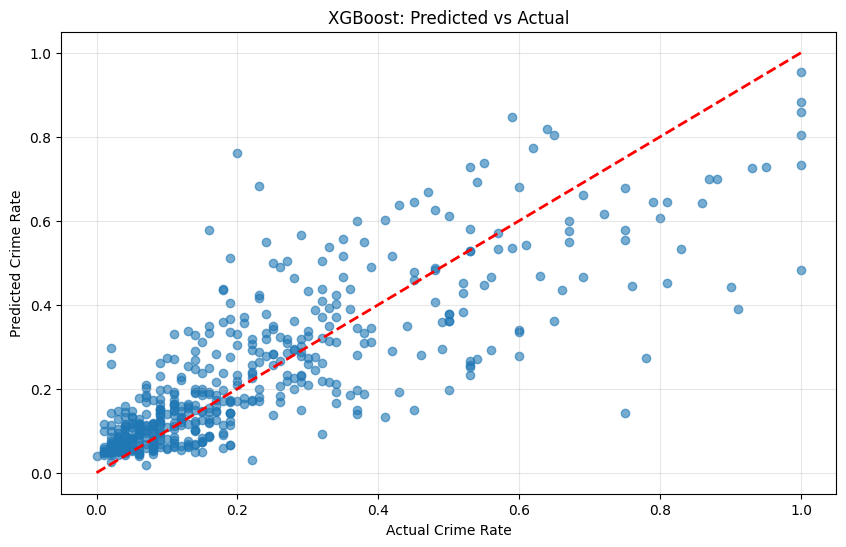


Top 10 Most Important Features:
    feature  importance
50       55    0.238989
44       49    0.094779
43       48    0.048469
62       67    0.041691
49       54    0.038774
3         8    0.033574
10       15    0.026513
69       74    0.018346
68       73    0.018159
2         7    0.016631


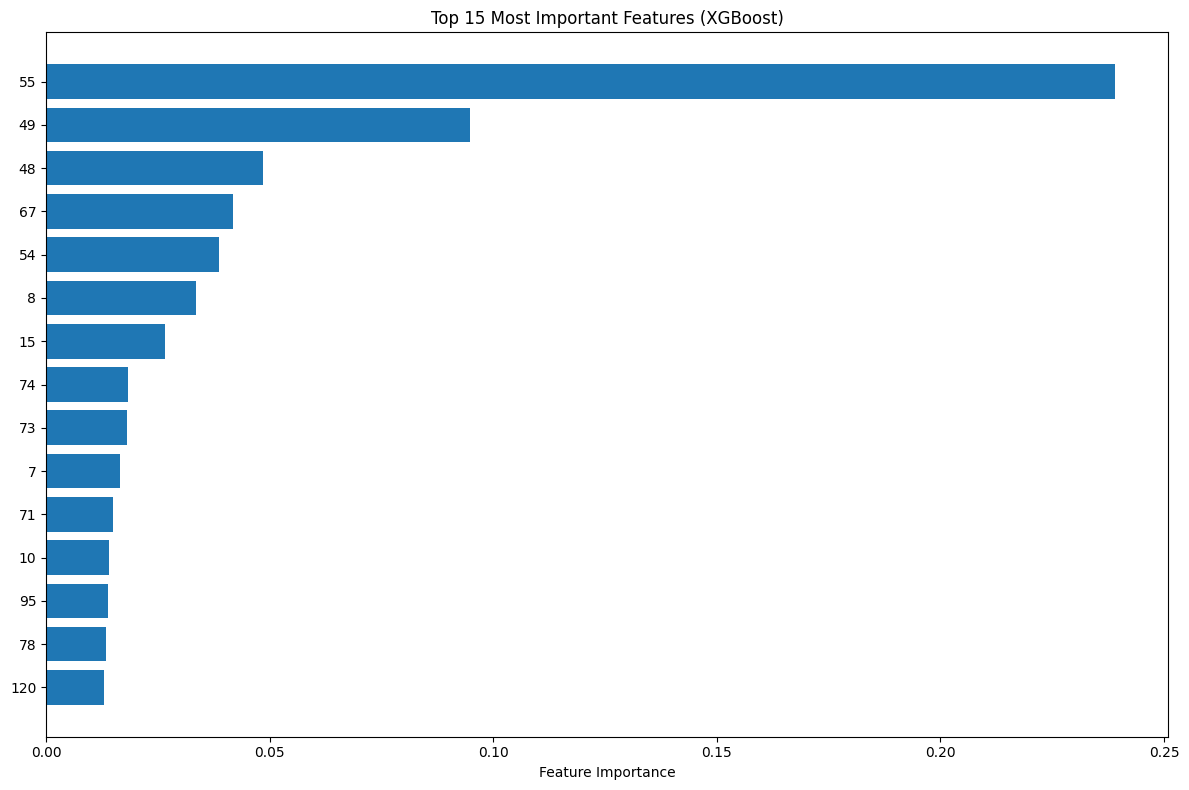

In [ ]:
param_grid = {
    'reg_alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best XGBoost Parameters: {best_params}")

xgb_final = xgb.XGBRegressor(
    reg_alpha=best_params['reg_alpha'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    n_estimators=best_params['n_estimators'],
    random_state=42,
    n_jobs=-1
)
xgb_final.fit(X_train, y_train)

y_train_pred_xgb = xgb_final.predict(X_train)
y_test_pred_xgb = xgb_final.predict(X_test)

train_mse_xgb = mean_squared_error(y_train, y_train_pred_xgb)
test_mse_xgb = mean_squared_error(y_test, y_test_pred_xgb)
train_r2_xgb = r2_score(y_train, y_train_pred_xgb)
test_r2_xgb = r2_score(y_test, y_test_pred_xgb)

print(f"XGBoost - Test MSE: {test_mse_xgb:.6f}, Test R²: {test_r2_xgb:.6f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_xgb, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Crime Rate')
plt.ylabel('Predicted Crime Rate')
plt.title('XGBoost: Predicted vs Actual')
plt.grid(True, alpha=0.3)
plt.show()

feature_importance = xgb_final.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Features (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()